In [1]:
import sys
sys.path.append('../../ABEL/')
from abel import *

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp
import matplotlib.pyplot as plt
from abel.utilities.relativity import energy2gamma
import scipy.special as sc

In [3]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.length = 11 # [m]
stage.nom_energy_gain = 31.9e9 # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = True
stage.save_evolution = True
if stage.enable_radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 7500e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.01
source.bunch_length = 10e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.2e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
#beam = source.track()

"""
main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]
"""
# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1
shots = 1
num_jitter_values = 2
jitter_values = np.logspace(-6,-5.6,num_jitter_values)

In [4]:
# scan the driver timing jitter
linac.scan(f'scan_jitter_with_RR_{stage.enable_radiation_reaction}', 
           lambda obj, val: setattr(obj.stage.driver_source.jitter, 'x', val) or obj, 
           jitter_values,
           label='Driver jitter [$\mu m$]',
           scale=1e-6,
           num_shots_per_step=300, 
           parallel=False,
           overwrite=True);

>> SHOT 1/600
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 7500.5 GeV, -1.60 nC, 1.0% rms, 160.7/0.2 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 7512.6 GeV, -1.60 nC, 1.0% rms, 160.0/0.2 µm-rad)
>> SHOT 2/600
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 7499.7 GeV, -1.60 nC, 1.0% rms, 159.4/0.2 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 7507.3 GeV, -1.60 nC, 1.0% rms, 158.8/0.2 µm-rad)
>> SHOT 3/600
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 7498.5 GeV, -1.60 nC, 1.0% rms, 160.8/0.2 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 7510.7 GeV, -1.60 nC, 1.0% rms, 160.2/0.2 µm-rad)
>> SHOT 4/600
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 7501.0 GeV, -1.60 nC, 1.0% rms, 159.3/0.2 µm-rad)
Tracking element 2 (StageQuasistatic2d, stage 1, s = 11.0 m, 7512.0 GeV, -1.60 nC, 1.0% rms, 158.6/0.2 µm-rad)
>> SHOT 5/600
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 7500.2 GeV, -1.60 nC,

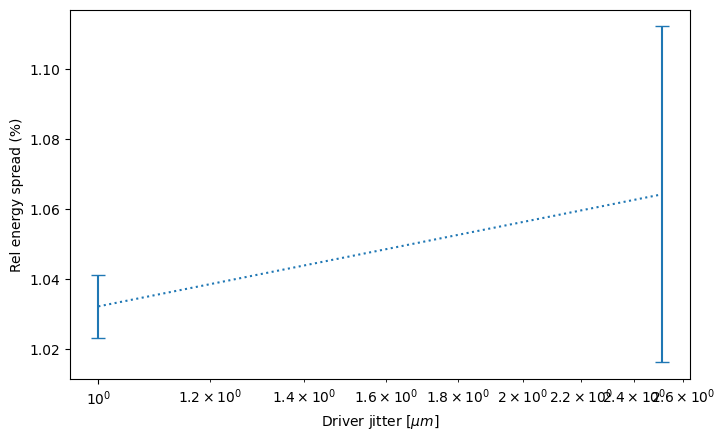

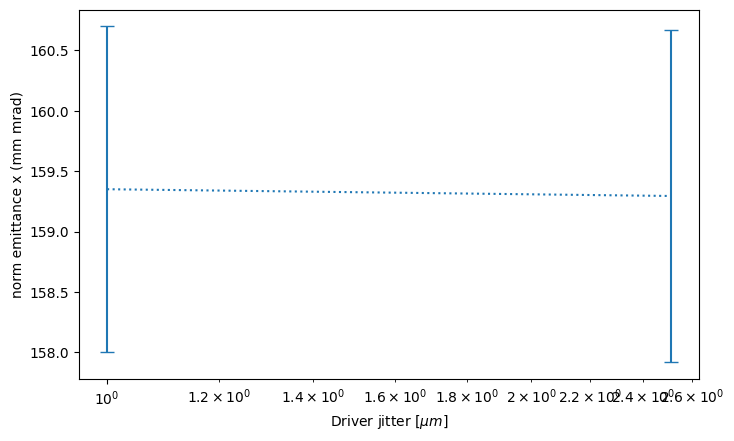

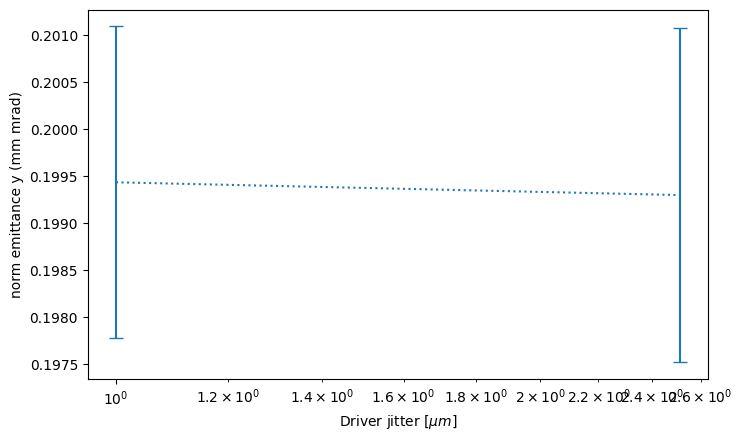

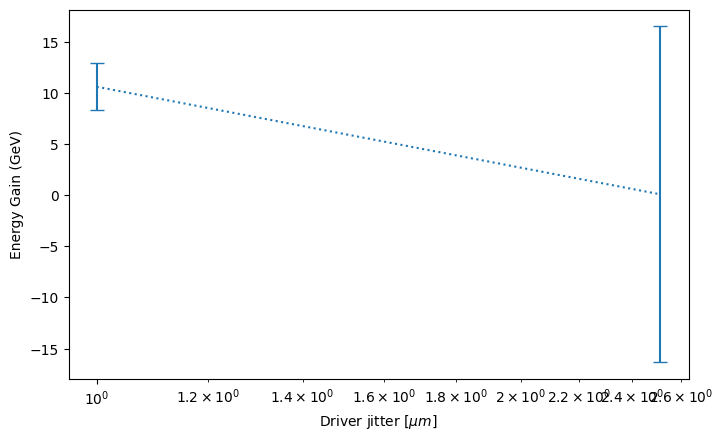

In [5]:
linac.plot_beam_function(Beam.rel_energy_spread, label='Rel energy spread (%)', scale=1e-2, xscale='log')
linac.plot_beam_function(Beam.norm_emittance_x, label='norm emittance x (mm mrad)', scale=1e-6, xscale='log')
linac.plot_beam_function(Beam.norm_emittance_y, label='norm emittance y (mm mrad)', scale=1e-6, xscale='log')
linac.plot_beam_function(lambda obj:obj.energy() - source.energy, label='Energy Gain (GeV)', scale=1e9, xscale='log')

In [6]:
list_of_E_ararys = [ [] for _ in range(num_jitter_values)]
print(list_of_E_ararys)
for j in range(num_jitter_values):
    Es = [linac[j,i].get_beam(-1).energy()/1e9 for i in range(linac.num_shots_per_step)]
    list_of_E_ararys[j] = Es

[[], []]


In [32]:
def rho(sig_jitter, El):
    gamma = energy2gamma(source.energy)
    kp = pp.k_p(stage.plasma_density)
    k_beta = kp/np.sqrt(2*gamma)
    sig_x_sq = source.emit_nx/k_beta/gamma
    sig_y_sq = source.emit_ny/k_beta/gamma
    
    energy_loss_beam = SI.e**2*stage.length/6/np.pi/SI.epsilon_0*\
    (gamma*k_beta)**4*(sig_x_sq+sig_y_sq)  /SI.e/1e9
    
    N = SI.e**2*stage.length/12/np.pi/SI.epsilon_0*(gamma*k_beta)**4/SI.e/1e9
    
    omega = sig_jitter**2/4/(sig_x_sq+sig_jitter**2)
    I_0 = sc.iv(0,omega*El/N)
    
    energy_loss_dist = 1/np.sqrt(sig_x_sq)/np.sqrt(sig_x_sq+sig_jitter**2) * 1/N\
    *I_0 * np.exp(El/N * (omega-1/2/sig_x_sq))
    return energy_loss_dist

<Figure size 640x480 with 0 Axes>

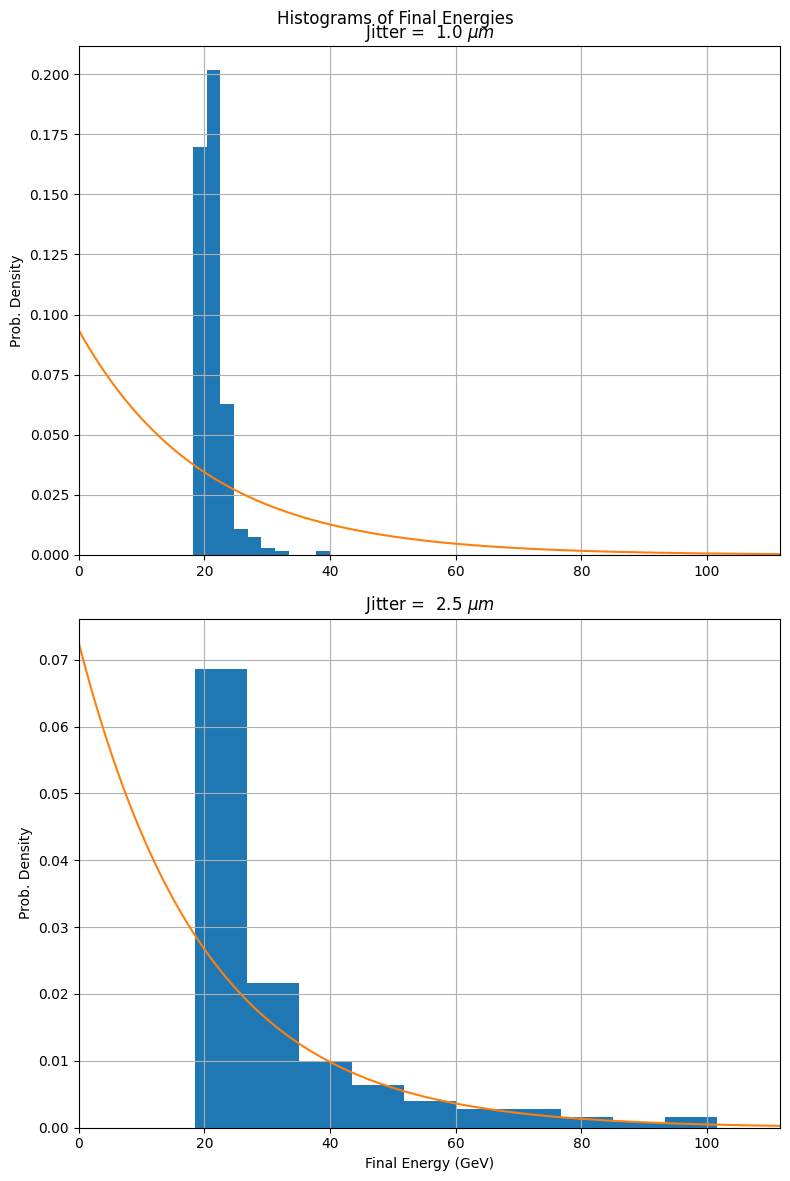

In [35]:
plt.subplots_adjust(hspace=0.4)
fig, axs = plt.subplots(num_jitter_values,1, figsize = (8,12))
fig.suptitle('Histograms of Final Energies')

gamma = energy2gamma(source.energy)
kp = pp.k_p(stage.plasma_density)
k_beta = kp/np.sqrt(2*gamma)
sig_x_sq = source.emit_nx/k_beta/gamma
sig_y_sq = source.emit_ny/k_beta/gamma
E_nom_final = (source.energy + stage.nom_energy_gain)/1e9

energy_loss_beam = SI.e**2*stage.length/6/np.pi/SI.epsilon_0*(gamma*k_beta)**4*(sig_x_sq+sig_y_sq)  /SI.e/1e9

xlim = [0,max(E_nom_final - np.array(list_of_E_ararys[-1]))+10]
Els = np.linspace(xlim[0],xlim[-1], 1000)

for j, ax in enumerate(axs):
    ax.hist(E_nom_final - np.array(list_of_E_ararys[j]), bins =10, density = True, stacked = True)
    ax.plot(Els, rho(jitter_values[j],Els))
    ax.set_title(f'Jitter = {jitter_values[j]*1e6: .1f} $\mu m$')
    ax.set_xlim(xlim)
    ax.set_ylabel('Prob. Density')
    ax.grid()
axs[-1].set_xlabel('Final Energy (GeV)')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

#fig.savefig(f'Plots/Jitter/final_energy_histograms_\
#{num_jitter_values}_jitter_values', bbox_inches = 'tight')